<img src="assets/pollution.jpg" width="600" height="400">

# Сегментация загрязнений на основе спутниковых снимков

**Сегментация нефтяных загрязнений** — это важная задача в области экологического мониторинга и анализа данных, которая заключается в автоматическом выделении областей, загрязнённых нефтью, на изображениях или спутниковых снимках. Эта задача играет ключевую роль в оперативном обнаружении и оценке масштабов загрязнений, что позволяет своевременно принимать меры по их ликвидации и минимизировать ущерб для окружающей среды.

Снимки сделанные с помощью SAR являются наиболее подходящими для поиска нефтянных утечек по нескольким причинам:
1. Всепогодность:

    * SAR может работать в любых погодных условиях, включая облачность, туман, дождь и ночное время. Это критически важно для оперативного мониторинга разливов нефти, которые часто происходят в сложных метеоусловиях.

2. Чувствительность к изменениям на поверхности воды:

    * Нефтяные пленки изменяют шероховатость поверхности воды, что влияет на отражение радиоволн. SAR способен улавливать эти изменения, так как нефтяные пятна выглядят как темные области на снимках (из-за снижения обратного рассеяния сигнала).

3. Широкий охват:

    * SAR-спутники могут покрывать большие площади океана, что позволяет оперативно обнаруживать разливы на обширных территориях.

4. Высокая детализация:

    * Современные SAR-системы обеспечивают высокое разрешение, что позволяет обнаруживать даже небольшие разливы нефти.

Датасет со снимками SAR - https://www.kaggle.com/datasets/nabilsherif/oil-spill

In [ ]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import os
import shutil
import random
import kagglehub 
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Callable

In [ ]:
SEED = 666
DATA_PATH = Path('data')
MODELS_PATH = Path('service/models')
IMG_SIZE = 256
DROPOUT = 0.2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16 
NUM_WORKERS = os.cpu_count()

In [17]:
random.seed(SEED)
    
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# Формируем данные

Скачаем датасет и переместим его в нашу папку

In [ ]:
temp_data = kagglehub.dataset_download("nabilsherif/oil-spill") 

source = Path(temp_data) / 'oil-spill'

shutil.move(source, DATA_PATH) 

print(f'Files has been downloaded in {DATA_PATH}')

Разработанный набор данных (~400 МБ) содержит около 1000 изображений для обучения и 110 изображений для тестирования, на которых изображены экземпляры 5 классов, а именно: разлив нефти, объекты похожие на разлив нефти, участки суши, судна и моря.

Ссылка на статью про датасет и оценку моделей на нем - https://www.mdpi.com/2072-4292/11/15/1762 

Посмотрим на датасет, какое изображение должно поступать на вход нашей модели и каким должен быть результат

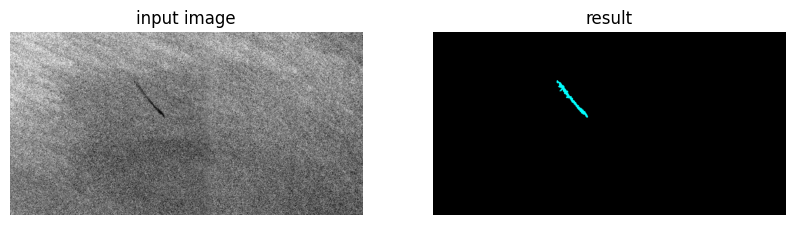

In [19]:
image1 = Image.open(Path(DATA_PATH) / 'train/images/img_0001.jpg')
image2 = Image.open(Path(DATA_PATH) / 'train/labels/img_0001.png')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

axes[0].imshow(image1)
axes[0].axis("off")  
axes[0].set_title("input image")

axes[1].imshow(image2)
axes[1].axis("off")  
axes[1].set_title("result")

plt.show() 

Наша задача по полученному чб снимку, выдать маску на которой голубой цвет соответствует нефтяным пятнам, красный — объектам, похожим на нефтяные пятна, коричневый — кораблям, зеленый — суше, а черный — поверхности моря.

Создадим трансформации которые приведут снимок к нужному размеру и переведут его в `torch.tensor`

In [20]:
X_trans = transforms.Compose([ 
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

y_trans = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

Создадим датасеты и даталоадеры для обучения и тестирования

In [21]:
X_train_paths = sorted(list(os.walk(DATA_PATH / 'train/images'))[0][2])
y_train_paths = sorted(list(os.walk(DATA_PATH / 'train/labels'))[0][2])

X_test_paths = sorted(list(os.walk(DATA_PATH / 'test/images'))[0][2])
y_test_paths = sorted(list(os.walk(DATA_PATH / 'test/labels'))[0][2])


train_dataset = []
test_dataset = []

for ind in range(len(X_train_paths)):
    X = X_trans(Image.open(f'{DATA_PATH}/train/images/{X_train_paths[ind]}'))
    y = y_trans(Image.open(f'{DATA_PATH}/train/labels/{y_train_paths[ind]}'))
    train_dataset.append((X, y))

for ind in range(len(X_test_paths)):
    X = X_trans(Image.open(f'{DATA_PATH}/test/images/{X_test_paths[ind]}'))
    y = y_trans(Image.open(f'{DATA_PATH}/test/labels/{y_test_paths[ind]}'))
    test_dataset.append((X, y))


train_dataloader = DataLoader(train_dataset,
                              shuffle=True,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset,
                             shuffle=False,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)

Взглянем на случайные элементы даталоадера

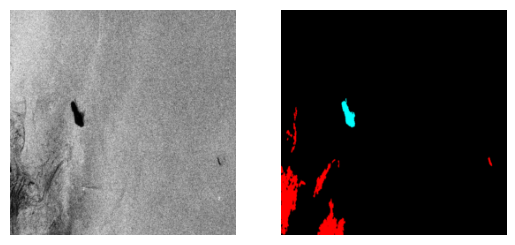

In [22]:
sample = random.choice(list(train_dataloader))

plt.subplot(1, 2, 1)
plt.imshow(sample[0][0].permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(sample[1][0].permute(1, 2, 0))
plt.axis(False)

plt.show()

# UNet
В качестве модели будем использовать UNet

![](assets/unet_arch.png)


[U-Net: Convolutional Networks for Biomedical
Image Segmentation](https://arxiv.org/pdf/1505.04597) - ссылка на статью

In [23]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.encode1 = nn.Sequential( # (3, 256, 256) + pool -> (16, 128, 128) 
            nn.Conv2d(3, 16, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.ReLU(),
        )

        self.encode2 = nn.Sequential( # (16, 128, 128)  -> (32, 64, 64) 
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
        )

        self.encode3 = nn.Sequential( # (32, 64, 64) -> (64, 32, 32)
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
        )

        self.encode4 = nn.Sequential( # (64, 32, 32) -> (128, 16, 16)
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(),
        )

        self.encode5 = nn.Sequential( # (128, 16, 16) -> (256, 8, 8)
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
        )

        self.bottleneck = nn.Sequential( # (256, 8, 8) -> (256, 8, 8) -> (256, 8, 8)
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Upsample(16),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU()
        )
        self.decode1 = nn.Sequential( # (512, 8, 8) -> (128, 16, 16)
            nn.Conv2d(512, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Upsample(32),
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.ReLU()
        )
        self.decode2 = nn.Sequential( # (128, 16, 16) -> (64, 32, 32)
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(),
            nn.Upsample(64),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.ReLU()
        )
        self.decode3 = nn.Sequential( # (128, 32, 32) -> (32, 64, 64)
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Upsample(128),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.ReLU()
        )
        self.decode4 = nn.Sequential( # (64, 64, 64) -> (16, 128, 128)
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Upsample(256),
            nn.Conv2d(32, 16, 3, 1, 1),
            nn.Dropout(DROPOUT),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(16, 3, 3, 1, 1),
            nn.ReLU()

        )


    def forward(self, x):
        # encoding
        e1 = self.encode1(x)
        e2 = self.encode2(self.pool(e1))
        e3 = self.encode3(self.pool(e2))
        e4 = self.encode4(self.pool(e3))
        e5 = self.encode5(self.pool(e4))

        #bottleneck
        bottle = self.bottleneck(e5)


        #decoding
        d1 = self.decode1(torch.cat((bottle, e5), 1))
        d2 = self.decode2(torch.cat((d1, e4), 1))
        d3 = self.decode3(torch.cat((d2, e3), 1))
        d4 = self.decode4(torch.cat((d3, e2), 1))

        return d4
    
unet_model = UNet().to(DEVICE)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=unet_model.parameters(), lr=3e-4)

Посмотрим сколько параметров у модели

In [24]:
def count_params(model: nn.Module):
    count = 0
    for param in model.parameters():
        count += param.numel()
    return count
count_params(unet_model)

5694723

Протестируем модель

In [25]:
test_pred = unet_model(train_dataset[1][0].unsqueeze(0).to(DEVICE))
test_pred.shape

torch.Size([1, 3, 256, 256])

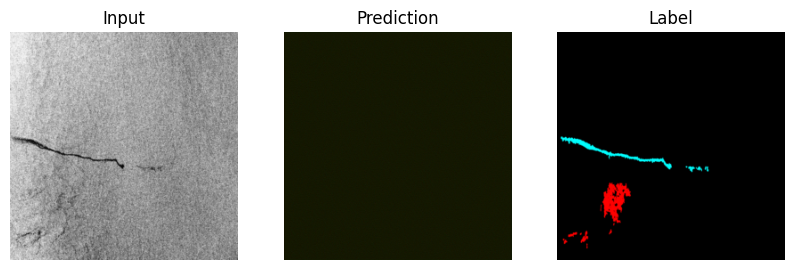

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

axes[0].imshow(train_dataset[1][0].permute(1, 2, 0))
axes[0].axis(False)
axes[0].set_title('Input')

axes[1].imshow(test_pred[0].permute(1, 2, 0).cpu().detach().numpy())
axes[1].axis(False)
axes[1].set_title('Prediction')

axes[2].imshow(train_dataset[1][1].permute(1, 2, 0))
axes[2].axis(False)
axes[2].set_title('Label')

plt.show()

Будем использовать следующую метрику:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

In [21]:
def IoU(pred: torch.tensor, target: torch.tensor, threshold=0.5):
    
    pred = (pred > threshold).float()
    
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    
    iou_value = intersection / union if union != 0 else torch.tensor(0.0)
    
    return iou_value.item()

In [22]:
IoU(test_pred, train_dataset[0][1].unsqueeze(0).to(DEVICE))

0.0

# Обучение

In [ ]:
def train(model: nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          optimizer: torch.optim,
          loss_fn: Callable,
          metric_fn: Callable,
          device: str,
          epochs: int,
          use_amp: bool,
          scaler: torch.amp.GradScaler,
          scheduler: torch.optim.lr_scheduler,
          show_step: int):

    results = {'train_loss': [], 'train_met': [], 'test_loss': [], 'test_met': []}
    for epoch in tqdm(range(epochs)):
        train_loss, train_met = 0, 0
        test_loss, test_met = 0, 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            model.train()
            with torch.autocast(device_type=device, enabled=use_amp):
                y_pred = model(X) 
                loss = loss_fn(y_pred, y)
            met = metric_fn(y_pred, y)
            train_loss += loss
            train_met += met
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            model.eval()
            with torch.inference_mode():
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
            met = metric_fn(y_pred, y)
            test_loss += loss
            test_met += met
        scheduler.step()
        if epoch % show_step == 0:
            print(f'EPOCH: {epoch}')
            print(f'train: metric - {train_met / len(train_dataloader)}% loss - {train_loss / len(train_dataloader)}')
            print(f'test: metric - {test_met / len(test_dataloader)}% loss - {test_loss / len(test_dataloader)}')
        results["train_loss"].append(train_loss / len(train_dataloader))
        results["train_met"].append(train_met / len(train_dataloader))
        results["test_loss"].append(test_loss / len(test_dataloader)) 
        results["test_met"].append(test_met / len(test_dataloader)) 
        print()
    return results

Запустим обучение модели

In [47]:
unet_res = train(model=unet_model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                metric_fn=IoU,
                scheduler=torch.optim.lr_scheduler.StepLR(optimizer, 75, 1),
                use_amp=True,
                device=DEVICE,
                scaler=torch.amp.GradScaler(),
                epochs=70,
                show_step=1)

  1%|▏         | 1/70 [00:09<11:13,  9.76s/it]

EPOCH: 0
train: metric - 0.0% loss - 0.029365891590714455
test: metric - 0.0% loss - 0.02341694012284279



  3%|▎         | 2/70 [00:19<11:02,  9.74s/it]

EPOCH: 1
train: metric - 0.07597939201121566% loss - 0.024951830506324768
test: metric - 0.0% loss - 0.02239062450826168



  4%|▍         | 3/70 [00:29<10:53,  9.75s/it]

EPOCH: 2
train: metric - 0.08374798950454634% loss - 0.024714680388569832
test: metric - 0.09404076216742396% loss - 0.022110382094979286



  6%|▌         | 4/70 [00:39<10:46,  9.80s/it]

EPOCH: 3
train: metric - 0.10713597689114283% loss - 0.02386193908751011
test: metric - 0.08067605597898364% loss - 0.022369302809238434



  7%|▋         | 5/70 [00:49<10:39,  9.84s/it]

EPOCH: 4
train: metric - 0.11413723141872435% loss - 0.02383805811405182
test: metric - 0.07404499660645213% loss - 0.022163081914186478



  9%|▊         | 6/70 [00:58<10:29,  9.84s/it]

EPOCH: 5
train: metric - 0.09692841976657436% loss - 0.023293180391192436
test: metric - 0.13168397253113134% loss - 0.02270972542464733



 10%|█         | 7/70 [01:08<10:19,  9.83s/it]

EPOCH: 6
train: metric - 0.12340604738583641% loss - 0.02320369891822338
test: metric - 0.13588805762784822% loss - 0.021493012085556984



 11%|█▏        | 8/70 [01:18<10:08,  9.82s/it]

EPOCH: 7
train: metric - 0.12018402658490925% loss - 0.023049961775541306
test: metric - 0.12724320111530169% loss - 0.022033387795090675



 13%|█▎        | 9/70 [01:28<09:56,  9.78s/it]

EPOCH: 8
train: metric - 0.12304417944479999% loss - 0.02281338721513748
test: metric - 0.13443217506366117% loss - 0.02260236069560051



 14%|█▍        | 10/70 [01:37<09:42,  9.71s/it]

EPOCH: 9
train: metric - 0.11711995294021946% loss - 0.022124523296952248
test: metric - 0.13749511300453118% loss - 0.020909296348690987



 16%|█▌        | 11/70 [01:47<09:35,  9.76s/it]

EPOCH: 10
train: metric - 0.12993373449832674% loss - 0.021917907521128654
test: metric - 0.11106175077813012% loss - 0.0215287022292614



 17%|█▋        | 12/70 [01:57<09:31,  9.85s/it]

EPOCH: 11
train: metric - 0.1527761414440142% loss - 0.02125740423798561
test: metric - 0.10584880571280207% loss - 0.019948266446590424



 19%|█▊        | 13/70 [02:07<09:20,  9.84s/it]

EPOCH: 12
train: metric - 0.1489449306021607% loss - 0.020799435675144196
test: metric - 0.1540759296289512% loss - 0.020176557824015617



 20%|██        | 14/70 [02:17<09:16,  9.93s/it]

EPOCH: 13
train: metric - 0.16153524604640782% loss - 0.020705467090010643
test: metric - 0.17706443582262313% loss - 0.019135259091854095



 21%|██▏       | 15/70 [02:27<09:03,  9.89s/it]

EPOCH: 14
train: metric - 0.17447794185921786% loss - 0.02107314206659794
test: metric - 0.07234465197793075% loss - 0.020205482840538025



 23%|██▎       | 16/70 [02:37<08:54,  9.90s/it]

EPOCH: 15
train: metric - 0.15645583377530178% loss - 0.02057969756424427
test: metric - 0.1363911953355585% loss - 0.019611617550253868



 24%|██▍       | 17/70 [02:47<08:46,  9.94s/it]

EPOCH: 16
train: metric - 0.1783054138400725% loss - 0.020191099494695663
test: metric - 0.11803194348301206% loss - 0.0191316157579422



 26%|██▌       | 18/70 [02:56<08:31,  9.83s/it]

EPOCH: 17
train: metric - 0.16614186000965891% loss - 0.020320145413279533
test: metric - 0.17619704668010985% loss - 0.019164064899086952



 27%|██▋       | 19/70 [03:06<08:22,  9.84s/it]

EPOCH: 18
train: metric - 0.2039130548872645% loss - 0.019307121634483337
test: metric - 0.21188532454626902% loss - 0.01860946975648403



 29%|██▊       | 20/70 [03:16<08:12,  9.86s/it]

EPOCH: 19
train: metric - 0.21763062273107825% loss - 0.01913502998650074
test: metric - 0.15152206484760558% loss - 0.019355764612555504



 30%|███       | 21/70 [03:26<08:02,  9.85s/it]

EPOCH: 20
train: metric - 0.21758583637457046% loss - 0.019064132124185562
test: metric - 0.2295425342661994% loss - 0.01803518831729889



 31%|███▏      | 22/70 [03:36<07:57,  9.94s/it]

EPOCH: 21
train: metric - 0.21796201476975094% loss - 0.018757414072752
test: metric - 0.16521841287612915% loss - 0.018109416589140892



 33%|███▎      | 23/70 [03:46<07:45,  9.89s/it]

EPOCH: 22
train: metric - 0.2547532089409374% loss - 0.01804768294095993
test: metric - 0.1885852962732315% loss - 0.01728111132979393



 34%|███▍      | 24/70 [03:56<07:37,  9.95s/it]

EPOCH: 23
train: metric - 0.24740781478347287% loss - 0.018166527152061462
test: metric - 0.24837134672062738% loss - 0.019091084599494934



 36%|███▌      | 25/70 [04:07<07:36, 10.14s/it]

EPOCH: 24
train: metric - 0.20716627639910531% loss - 0.019401567056775093
test: metric - 0.2103388554283551% loss - 0.01834488846361637



 37%|███▋      | 26/70 [04:17<07:27, 10.18s/it]

EPOCH: 25
train: metric - 0.24358189898350882% loss - 0.01824226975440979
test: metric - 0.16422513127326965% loss - 0.017171962186694145



 39%|███▊      | 27/70 [04:27<07:20, 10.23s/it]

EPOCH: 26
train: metric - 0.24920679368670023% loss - 0.017515601590275764
test: metric - 0.3043340912887028% loss - 0.016428807750344276



 40%|████      | 28/70 [04:38<07:14, 10.34s/it]

EPOCH: 27
train: metric - 0.2845190850988267% loss - 0.017189348116517067
test: metric - 0.2624130408678736% loss - 0.01610013283789158



 41%|████▏     | 29/70 [04:48<06:59, 10.24s/it]

EPOCH: 28
train: metric - 0.2710442046324412% loss - 0.01742151379585266
test: metric - 0.2594810745545796% loss - 0.015572721138596535



 43%|████▎     | 30/70 [04:58<06:48, 10.20s/it]

EPOCH: 29
train: metric - 0.26985730786645223% loss - 0.017288973554968834
test: metric - 0.22494970155613764% loss - 0.016192955896258354



 44%|████▍     | 31/70 [05:08<06:37, 10.18s/it]

EPOCH: 30
train: metric - 0.2965694481418246% loss - 0.01666068471968174
test: metric - 0.23868813791445323% loss - 0.01615438424050808



 46%|████▌     | 32/70 [05:18<06:27, 10.19s/it]

EPOCH: 31
train: metric - 0.28050730590309414% loss - 0.016955163329839706
test: metric - 0.35550319296973093% loss - 0.015590816736221313



 47%|████▋     | 33/70 [05:28<06:13, 10.11s/it]

EPOCH: 32
train: metric - 0.3001378175048601% loss - 0.01695832423865795
test: metric - 0.3709716158253806% loss - 0.01447160355746746



 49%|████▊     | 34/70 [05:38<06:01, 10.03s/it]

EPOCH: 33
train: metric - 0.3057037971559025% loss - 0.016422472894191742
test: metric - 0.22285775201661245% loss - 0.016230596229434013



 50%|█████     | 35/70 [05:48<05:51, 10.03s/it]

EPOCH: 34
train: metric - 0.3272102382921037% loss - 0.016241995617747307
test: metric - 0.25172315005745205% loss - 0.015118309296667576



 51%|█████▏    | 36/70 [05:58<05:39,  9.98s/it]

EPOCH: 35
train: metric - 0.3309101432798401% loss - 0.015542339533567429
test: metric - 0.2745599789278848% loss - 0.014854774810373783



 53%|█████▎    | 37/70 [06:08<05:32, 10.07s/it]

EPOCH: 36
train: metric - 0.33853649336194236% loss - 0.015594659373164177
test: metric - 0.2794610155480249% loss - 0.01516232080757618



 54%|█████▍    | 38/70 [06:18<05:19,  9.99s/it]

EPOCH: 37
train: metric - 0.33036098617409904% loss - 0.015523689799010754
test: metric - 0.2637705143008913% loss - 0.014381734654307365



 56%|█████▌    | 39/70 [06:28<05:08,  9.96s/it]

EPOCH: 38
train: metric - 0.34519513731911067% loss - 0.01551890280097723
test: metric - 0.2918851843902043% loss - 0.015238466672599316



 57%|█████▋    | 40/70 [06:38<04:59,  9.99s/it]

EPOCH: 39
train: metric - 0.3294211908701866% loss - 0.015899252146482468
test: metric - 0.26328151140894207% loss - 0.01553515624254942



 59%|█████▊    | 41/70 [06:48<04:48,  9.96s/it]

EPOCH: 40
train: metric - 0.34812289547352565% loss - 0.01531153917312622
test: metric - 0.26292737892695833% loss - 0.015414097346365452



 60%|██████    | 42/70 [06:58<04:40, 10.03s/it]

EPOCH: 41
train: metric - 0.3781348123909935% loss - 0.014096485450863838
test: metric - 0.3416865510599954% loss - 0.012971779331564903



 61%|██████▏   | 43/70 [07:08<04:30, 10.03s/it]

EPOCH: 42
train: metric - 0.38082806387590984% loss - 0.01382345613092184
test: metric - 0.33626566401549746% loss - 0.01429399847984314



 63%|██████▎   | 44/70 [07:18<04:22, 10.10s/it]

EPOCH: 43
train: metric - 0.38246120642575004% loss - 0.01348655391484499
test: metric - 0.354864701628685% loss - 0.013462167233228683



 64%|██████▍   | 45/70 [07:28<04:10, 10.03s/it]

EPOCH: 44
train: metric - 0.412645837025983% loss - 0.012634936720132828
test: metric - 0.43110446419034687% loss - 0.013573952950537205



 66%|██████▌   | 46/70 [07:38<03:59, 10.00s/it]

EPOCH: 45
train: metric - 0.40965557831620414% loss - 0.013011615723371506
test: metric - 0.3237834849527904% loss - 0.013316323049366474



 67%|██████▋   | 47/70 [07:48<03:50, 10.03s/it]

EPOCH: 46
train: metric - 0.41731108346628765% loss - 0.012537346221506596
test: metric - 0.3268007125173296% loss - 0.013182030990719795



 69%|██████▊   | 48/70 [07:58<03:40, 10.00s/it]

EPOCH: 47
train: metric - 0.4026931096164007% loss - 0.013301930390298367
test: metric - 0.3608033273901258% loss - 0.013642381876707077



 70%|███████   | 49/70 [08:08<03:31, 10.08s/it]

EPOCH: 48
train: metric - 0.4352650396407597% loss - 0.012377875857055187
test: metric - 0.27327095185007366% loss - 0.015105614438652992



 71%|███████▏  | 50/70 [08:19<03:21, 10.10s/it]

EPOCH: 49
train: metric - 0.4606172399861472% loss - 0.011843393556773663
test: metric - 0.36390951701572966% loss - 0.01298304833471775



 73%|███████▎  | 51/70 [08:29<03:11, 10.07s/it]

EPOCH: 50
train: metric - 0.4581424061741148% loss - 0.011565628461539745
test: metric - 0.2701892618622099% loss - 0.013846265152096748



 74%|███████▍  | 52/70 [08:39<03:01, 10.06s/it]

EPOCH: 51
train: metric - 0.4260186324753458% loss - 0.012618068605661392
test: metric - 0.3585763084036963% loss - 0.013167213648557663



 76%|███████▌  | 53/70 [08:49<02:51, 10.11s/it]

EPOCH: 52
train: metric - 0.46611536637185114% loss - 0.011290932074189186
test: metric - 0.3561781517096928% loss - 0.013053799979388714



 77%|███████▋  | 54/70 [08:59<02:40, 10.06s/it]

EPOCH: 53
train: metric - 0.4771878813940381% loss - 0.01118522509932518
test: metric - 0.43350433451788767% loss - 0.012647283263504505



 79%|███████▊  | 55/70 [09:09<02:30, 10.03s/it]

EPOCH: 54
train: metric - 0.4686242817413239% loss - 0.011358019895851612
test: metric - 0.37850624322891235% loss - 0.01330566219985485



 80%|████████  | 56/70 [09:19<02:20, 10.05s/it]

EPOCH: 55
train: metric - 0.4854098189444769% loss - 0.010892712511122227
test: metric - 0.32117198620523724% loss - 0.013761774636805058



 81%|████████▏ | 57/70 [09:29<02:10, 10.03s/it]

EPOCH: 56
train: metric - 0.4949339770135425% loss - 0.010520081035792828
test: metric - 0.4136940666607448% loss - 0.012687791138887405



 83%|████████▎ | 58/70 [09:39<02:00, 10.03s/it]

EPOCH: 57
train: metric - 0.489602396885554% loss - 0.010423168540000916
test: metric - 0.33572416646139963% loss - 0.015401815064251423



 84%|████████▍ | 59/70 [09:49<01:50, 10.03s/it]

EPOCH: 58
train: metric - 0.49561910591428243% loss - 0.010527277365326881
test: metric - 0.3255079686641693% loss - 0.01379826758056879



 86%|████████▌ | 60/70 [09:59<01:40, 10.09s/it]

EPOCH: 59
train: metric - 0.5043848095432161% loss - 0.010095197707414627
test: metric - 0.4262410317148481% loss - 0.012307541444897652



 87%|████████▋ | 61/70 [10:09<01:30, 10.10s/it]

EPOCH: 60
train: metric - 0.5162785743910169% loss - 0.009517548605799675
test: metric - 0.3809204910482679% loss - 0.012864898890256882



 89%|████████▊ | 62/70 [10:20<01:21, 10.16s/it]

EPOCH: 61
train: metric - 0.5126871826156737% loss - 0.009516776539385319
test: metric - 0.36222292695726666% loss - 0.014394017867743969



 90%|█████████ | 63/70 [10:30<01:11, 10.15s/it]

EPOCH: 62
train: metric - 0.5439257063562908% loss - 0.008975218050181866
test: metric - 0.3979197996003287% loss - 0.014012430794537067



 91%|█████████▏| 64/70 [10:40<01:01, 10.19s/it]

EPOCH: 63
train: metric - 0.5260405180946229% loss - 0.009765386581420898
test: metric - 0.3960434709276472% loss - 0.014047176577150822



 93%|█████████▎| 65/70 [10:50<00:50, 10.11s/it]

EPOCH: 64
train: metric - 0.5340410470962524% loss - 0.009337923489511013
test: metric - 0.40553862282208036% loss - 0.01306555699557066



 94%|█████████▍| 66/70 [11:00<00:40, 10.08s/it]

EPOCH: 65
train: metric - 0.5536324064882975% loss - 0.008886391296982765
test: metric - 0.4124963326113565% loss - 0.012991029769182205



 96%|█████████▌| 67/70 [11:10<00:30, 10.14s/it]

EPOCH: 66
train: metric - 0.5607975163157024% loss - 0.008312811143696308
test: metric - 0.4239280734743391% loss - 0.012292252853512764



 97%|█████████▋| 68/70 [11:20<00:20, 10.12s/it]

EPOCH: 67
train: metric - 0.554782768090566% loss - 0.008427612483501434
test: metric - 0.401235112122127% loss - 0.012990857474505901



 99%|█████████▊| 69/70 [11:31<00:10, 10.18s/it]

EPOCH: 68
train: metric - 0.5771740362757728% loss - 0.007859407924115658
test: metric - 0.4073254976953779% loss - 0.013084795325994492



100%|██████████| 70/70 [11:41<00:00, 10.02s/it]

EPOCH: 69
train: metric - 0.5892309518087477% loss - 0.007636839058250189
test: metric - 0.40400754128183636% loss - 0.013944086618721485



# Результаты

Взглянем на графики метрики и ошибки

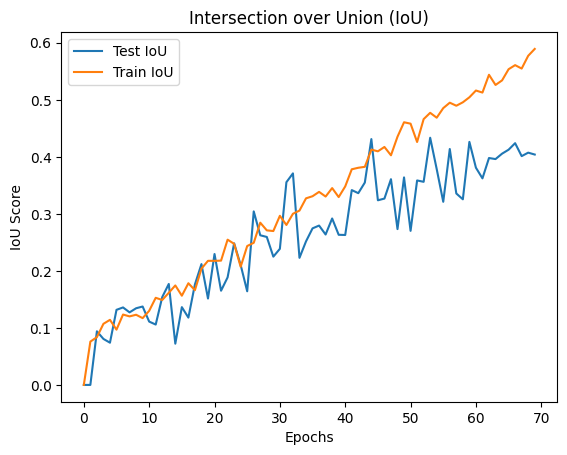

In [48]:
plt.plot(unet_res['test_met'], label='Test IoU')
plt.plot(unet_res['train_met'], label='Train IoU')

plt.title('Intersection over Union (IoU)')
plt.xlabel('Epochs')  
plt.ylabel('IoU Score')  

plt.legend()

plt.show()

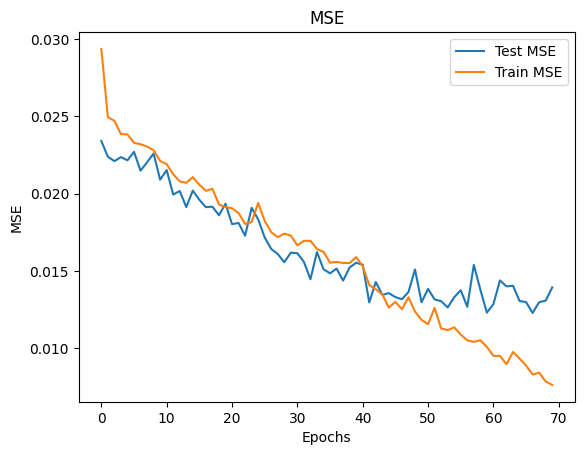

In [49]:
plt.plot([i.item()for i in unet_res['test_loss']], label='Test MSE')
plt.plot([i.item()for i in unet_res['train_loss']], label='Train MSE')

plt.title('MSE')

plt.xlabel('Epochs')  
plt.ylabel('MSE')  

plt.legend()

plt.show()

Оценим предсказание модели

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1022397].


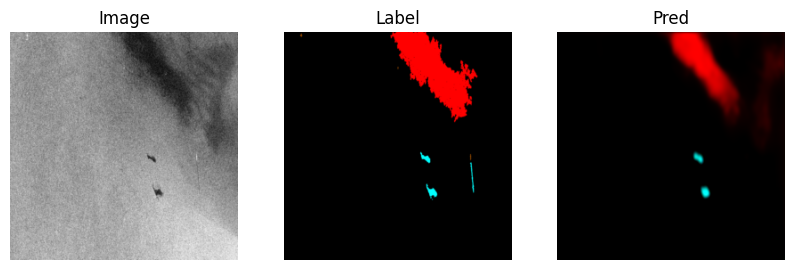

IoU - 0.5534703731536865


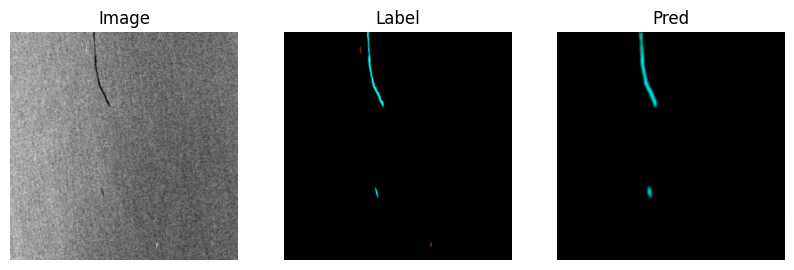

IoU - 0.5693506598472595


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1370629].


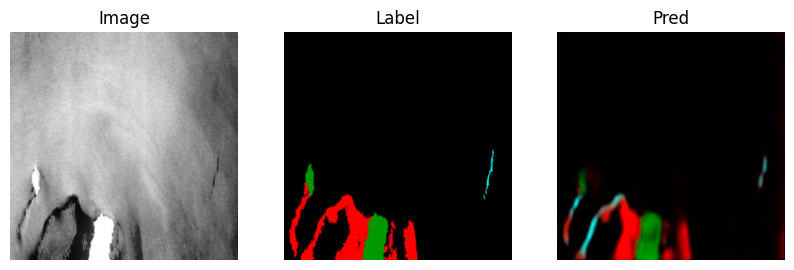

IoU - 0.44535985589027405


In [56]:
unet_model.eval()
for i in range(3):
    ind = random.choice(range(len(test_dataset)))
    test_pred = unet_model(test_dataset[ind][0].unsqueeze(0).to(DEVICE))

    fig, axes = plt.subplots(1, 3, figsize=(10, 8))

    axes[0].imshow(test_dataset[ind][0].permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
    axes[0].set_title("Image")
    axes[0].axis(False)

    axes[1].imshow(test_dataset[ind][1].permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
    axes[1].set_title("Label")
    axes[1].axis(False)

    axes[2].imshow(test_pred.squeeze(0).permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
    axes[2].set_title("Pred")
    axes[2].axis(False)

    plt.show()
    print(f"IoU - {IoU(test_pred, test_dataset[ind][1].unsqueeze(0).to(DEVICE))}")

Подводя итоги, можно заключить, что данная архитектура демонстрирует потенциал для решения поставленной задачи. Однако анализ графиков указывает на наличие переобучения модели, что проявляется в снижении её обобщающей способности. Для улучшения результатов в дальнейшем необходимо сосредоточиться на устранении этой проблемы. Возможные направления работы включают: увеличение объема обучающих данных, использование аугментации данных, а также настройку гиперпараметров модели, таких как скорость обучения или размер батча. 

# Сохраняем веса

In [ ]:
if not os.path.exists(MODELS_PATH):
    os.mkdir(MODELS_PATH)

torch.save(unet_model.state_dict(), f="models/model_8.pth")